In [1]:
!pip install librosa soundfile 


**Downsamling and Preprocessing**

In [3]:
import os
import numpy as np
import librosa
import soundfile as sf
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler

def pad_waveform(waveform, desired_length):
    if len(waveform) < desired_length:
        pad_width = desired_length - len(waveform)
        waveform = np.pad(waveform, (0, pad_width), mode='constant')
    else:
        waveform = waveform[:desired_length]
    return waveform

def downsample_audio(input_dir, output_dir, target_sr=2000, max_len_16k=269760):
    os.makedirs(output_dir, exist_ok=True)
    scaler = MinMaxScaler(feature_range=(-1, 1))

    for subdir, dirs, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.wav') and ("1240" in file or "1241" in file):  # ✅ Allow both 1240 and 1241
                file_path = os.path.join(subdir, file)

                waveform_16k, sr = librosa.load(file_path, sr=16000)
                waveform_16k = scaler.fit_transform(waveform_16k.reshape(-1, 1)).flatten()
                waveform_16k = pad_waveform(waveform_16k, max_len_16k)

                waveform_2k = librosa.resample(waveform_16k, orig_sr=16000, target_sr=target_sr)
                waveform_2k = pad_waveform(waveform_2k, max_len_16k // 8)

                output_path = os.path.join(output_dir, f"2k_{file}")
                sf.write(output_path, waveform_2k, target_sr)
    print("✅ Downsampling & padding completed.")

# Paths
original_directory = '/kaggle/input/16000hzwav/16000Hz/103'  # ✅ Folder containing 1240 and 1241
downsampled_directory = '/kaggle/working/2kHz_audio'

# Start Step 1
downsample_audio(original_directory, downsampled_directory)

# ------------------------------
# STEP 2: Prepare Data
# ------------------------------

def prepare_data(downsampled_dir, original_dir, target_sr=2000, original_sr=16000, input_len=33720, target_len=269760):
    input_data = []
    target_data = []
    total_duration_seconds = 0

    for subdir, dirs, files in os.walk(downsampled_dir):
        for file in files:
            if file.endswith('.wav') and file.startswith("2k_"):
                original_file = file.replace("2k_", "")
                if not ("1240" in original_file or "1241" in original_file):
                    continue

                # Load downsampled 2kHz
                waveform_2k, _ = librosa.load(os.path.join(subdir, file), sr=target_sr)
                waveform_2k = pad_waveform(waveform_2k, input_len)

                # Search for original file inside original_dir recursively
                original_path = None
                for root, _, filenames in os.walk(original_dir):
                    if original_file in filenames:
                        original_path = os.path.join(root, original_file)
                        break

                if original_path is None:
                    continue  # Original file not found

                waveform_16k, _ = librosa.load(original_path, sr=original_sr)
                waveform_16k = pad_waveform(waveform_16k, target_len)

                input_data.append(waveform_2k)
                target_data.append(waveform_16k)

                total_duration_seconds += (target_len / original_sr)

    input_data = np.array(input_data).reshape(-1, input_len, 1)
    target_data = np.array(target_data).reshape(-1, target_len, 1)

    total_minutes = total_duration_seconds / 60

    print(f"✅ Prepared {len(input_data)} samples.")
    print(f"🕒 Total duration: {total_minutes:.2f} minutes.")

    return input_data, target_data

input_len = 33720
target_len = 269760

# Start Step 2
input_data, target_data = prepare_data(downsampled_directory, original_directory, input_len=input_len, target_len=target_len)


✅ Downsampling & padding completed.
✅ Prepared 102 samples.
🕒 Total duration: 28.66 minutes.


In [4]:

# STEP 3: CNN SR Model
# ------------------------------

def create_cnn_sr_model(input_shape):
    model = models.Sequential()
    
    # Encoder
    model.add(layers.Conv1D(64, kernel_size=9, padding='same', activation='relu', input_shape=input_shape))
    model.add(layers.Conv1D(128, kernel_size=5, padding='same', activation='relu'))
    model.add(layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'))

    # Upsampling: x2 x2 x2 = 8x
    model.add(layers.Conv1DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu'))  # x2
    model.add(layers.Conv1DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu'))   # x2
    model.add(layers.Conv1DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu'))   # x2

    # Final output layer
    model.add(layers.Conv1D(1, kernel_size=9, padding='same', activation='linear'))

    model.compile(optimizer='adam', loss='mse')
    return model

cnn_sr_model = create_cnn_sr_model((input_len, 1))
cnn_sr_model.summary()

# ------------------------------
# STEP 4: Train the Model
# ------------------------------

cnn_sr_model.fit(input_data, target_data, epochs=10, batch_size=4)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1745691431.813458      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745691431.814147      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 33720, 64)           │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 33720, 128)          │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 33720, 256)          │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose (Conv1DTranspose)   │ (None, 67440, 128)          │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_1 (Conv1DTranspose) │ (None, 134880, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_transpose_2 (Conv1DTranspose) │ (None, 269760, 32)          │           8,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 269760, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 312,833 (1.19 MB)

 Trainable params: 312,833 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1745691436.092063     112 service.cc:148] XLA service 0x7d5254451c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745691436.092593     112 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745691436.092613     112 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745691436.422823     112 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/26 ━━━━━━━━━━━━━━━━━━━━ 4:30 11s/step - loss: 5.8921e-04

I0000 00:00:1745691444.029259     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 ━━━━━━━━━━━━━━━━━━━━ 18s 301ms/step - loss: 6.5077e-04
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 2.9594e-04
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 2.7219e-04
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - loss: 2.6416e-04
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 2.4285e-04
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - loss: 2.3815e-04
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 2.2497e-04
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - loss: 2.3714e-04
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - loss: 2.4775e-04
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - loss: 2.2554e-04


✅ Model saved to /kaggle/working/cnn_audio_sr_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
🔊 Predicted audio saved to /kaggle/working/output_predicted_sr2.wav
✅ Ground truth saved to /kaggle/working/ground_truth.wav


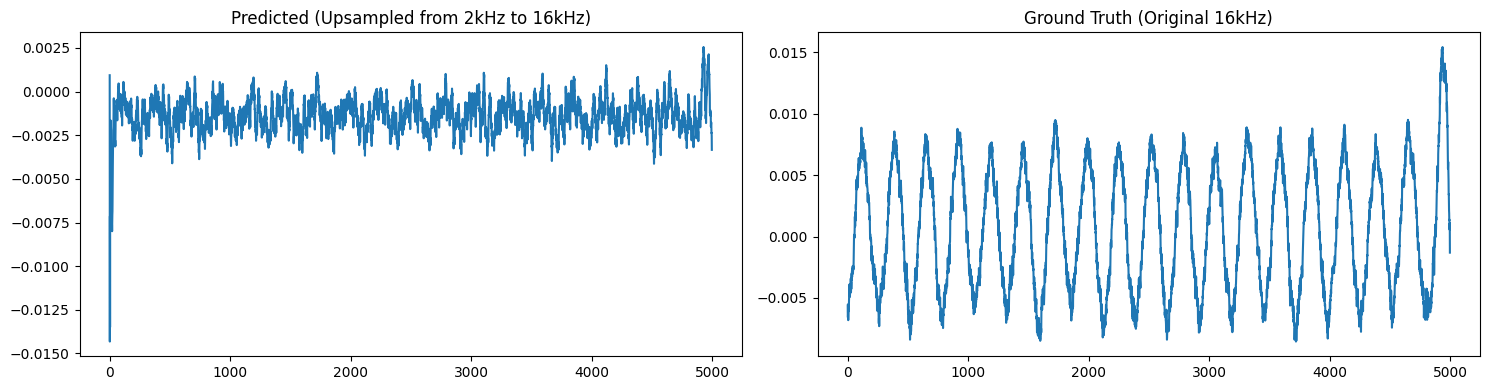

In [36]:

model_path = "/kaggle/working/cnn_audio_sr_model.h5"
cnn_sr_model.save(model_path)
print(f"✅ Model saved to {model_path}")

import matplotlib.pyplot as plt

# Pick a sample
i = 2
low_sr_input = input_data[i].reshape(1, input_len, 1)
predicted = cnn_sr_model.predict(low_sr_input)[0].flatten()
ground_truth = target_data[i].flatten()

# Save the predicted output as a WAV file
output_audio_path = "/kaggle/working/output_predicted_sr2.wav"
sf.write(output_audio_path, predicted, 16000)
print(f"🔊 Predicted audio saved to {output_audio_path}")

# Also save ground truth for comparison
gt_audio_path = "/kaggle/working/ground_truth.wav"
sf.write(gt_audio_path, ground_truth, 16000)
print(f"✅ Ground truth saved to {gt_audio_path}")


plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(predicted[:5000])
plt.title("Predicted (Upsampled from 2kHz to 16kHz)")

plt.subplot(1, 2, 2)
plt.plot(ground_truth[:5000])
plt.title("Ground Truth (Original 16kHz)")

plt.tight_layout()
plt.show()


In [25]:
from IPython.display import Audio
print("Predicted Output:")
display(Audio(data=predicted.squeeze(), rate=16000))

print("Ground Truth:")
display(Audio(data=ground_truth.squeeze(), rate=16000))


Predicted Output:


Ground Truth:


****CNN with SE****

In [8]:

# ------------------------------
# STEP 3: CNN SE Model
# ------------------------------

def se_block(input_tensor, reduction_ratio=8):
    filters = input_tensor.shape[-1]
    se = layers.GlobalAveragePooling1D()(input_tensor)
    se = layers.Dense(filters // reduction_ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, filters))(se)
    return layers.Multiply()([input_tensor, se])

def create_cnn_se_model_with_attention(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv1D(64, kernel_size=9, padding='same', activation='relu')(inputs)
    x = se_block(x)  # Attention block

    x = layers.Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = se_block(x)  # Attention block

    x = layers.Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = se_block(x)  # Attention block

    # Upsampling
    x = layers.Conv1DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu')(x)

    outputs = layers.Conv1D(1, kernel_size=9, padding='same', activation='linear')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model


cnn_se_model = create_cnn_se_model_with_attention((input_len, 1))
cnn_se_model.summary()

# ------------------------------
# STEP 4: Train the Model
# ------------------------------

cnn_se_model.fit(input_data, target_data, epochs=10, batch_size=4)


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 33720, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 33720, 64)      │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 64)             │              0 │ conv1d_4[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 8)              │            520 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │            576 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 64)          │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 33720, 64)      │              0 │ conv1d_4[0][0],        │
│                           │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 33720, 128)     │         41,088 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ conv1d_5[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 16)             │          2,064 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │          2,176 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 128)         │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 33720, 128)     │              0 │ conv1d_5[0][0],        │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 33720, 256)     │         98,560 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ conv1d_6[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 32)             │          8,224 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)      

 Total params: 334,841 (1.28 MB)

 Trainable params: 334,841 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 14s 251ms/step - loss: 6.7042e-04
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - loss: 6.4463e-04
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - loss: 4.0093e-04
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 2.8971e-04
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 2.5008e-04
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - loss: 2.9088e-04
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - loss: 2.6003e-04
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 172ms/step - loss: 2.4689e-04
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 2.4677e-04
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 2.3052e-04


✅ Model saved to /kaggle/working/cnn_audio_se_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
🔊 Predicted audio saved to /kaggle/working/output_predicted_se3.wav
✅ Ground truth saved to /kaggle/working/ground_truth.wav


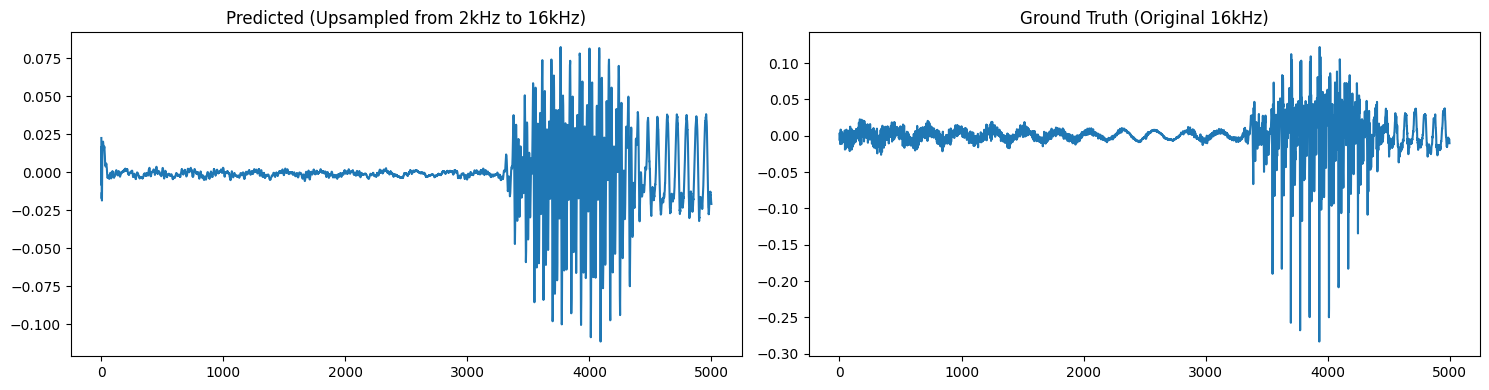

In [32]:

model_path = "/kaggle/working/cnn_audio_se_model.h5"
cnn_se_model.save(model_path)
print(f"✅ Model saved to {model_path}")

import matplotlib.pyplot as plt

i = 3
low_sr_input = input_data[i].reshape(1, input_len, 1)
predicted = cnn_se_model.predict(low_sr_input)[0].flatten()
ground_truth = target_data[i].flatten()

output_audio_path = "/kaggle/working/output_predicted_se3.wav"
sf.write(output_audio_path, predicted, 16000)
print(f"🔊 Predicted audio saved to {output_audio_path}")

gt_audio_path = "/kaggle/working/ground_truth.wav"
sf.write(gt_audio_path, ground_truth, 16000)
print(f"✅ Ground truth saved to {gt_audio_path}")

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(predicted[:5000])
plt.title("Predicted (Upsampled from 2kHz to 16kHz)")

plt.subplot(1, 2, 2)
plt.plot(ground_truth[:5000])
plt.title("Ground Truth (Original 16kHz)")

plt.tight_layout()
plt.show()

In [10]:
from IPython.display import Audio
print("Predicted Output:")
display(Audio(data=predicted.squeeze(), rate=16000))

print("Ground Truth:")
display(Audio(data=ground_truth.squeeze(), rate=16000))


Predicted Output:


Ground Truth:


**CNN with ECA**

In [11]:


def eca_block(input_tensor, gamma=2, b=1):
    filters = input_tensor.shape[-1]
    if filters is None:
        filters = tf.shape(input_tensor)[-1]

    t = int(abs((np.log2(filters) + b) / gamma))
    k_size = t if t % 2 else t + 1

    squeeze = layers.GlobalAveragePooling1D()(input_tensor)
    squeeze = layers.Reshape((filters, 1))(squeeze)

    conv = layers.Conv1D(1, kernel_size=k_size, padding='same', use_bias=False)(squeeze)
    conv = layers.Reshape((1, filters))(conv)

    scale = layers.Activation('sigmoid')(conv)
    return layers.Multiply()([input_tensor, scale])

def create_cnn_sr_model_with_eca(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(64, kernel_size=9, padding='same', activation='relu')(inputs)
    x = eca_block(x)

    x = layers.Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = eca_block(x)

    x = layers.Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = eca_block(x)

    x = layers.Conv1DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu')(x)

    outputs = layers.Conv1D(1, kernel_size=9, padding='same', activation='linear')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

cnn_eca_model = create_cnn_sr_model_with_eca((input_len, 1))
cnn_eca_model.summary()

# ------------------------------
# STEP 4: Train the Model
# ------------------------------

cnn_eca_model.fit(input_data, target_data, epochs=10, batch_size=1)

# Save
cnn_eca_model.save('/kaggle/working/cnn_sr_model_with_eca.h5')
print("✅ Model saved as 'cnn_sr_model_with_eca.h5'.")


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 33720, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 33720, 64)      │            640 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ conv1d_8[0][0]         │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_3 (Reshape)       │ (None, 64, 1)          │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 64, 1)          │              3 │ reshape_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_4 (Reshape)       │ (None, 1, 64)          │              0 │ conv1d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 1, 64)          │              0 │ reshape_4[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_3 (Multiply)     │ (None, 33720, 64)      │              0 │ conv1d_8[0][0],        │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 33720, 128)     │         41,088 │ multiply_3[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 128)            │              0 │ conv1d_10[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 128, 1)         │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_11 (Conv1D)        │ (None, 128, 1)         │              5 │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_6 (Reshape)       │ (None, 1, 128)         │              0 │ conv1d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 1, 128)         │              0 │ reshape_6[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_4 (Multiply)     │ (None, 33720, 128)     │              0 │ conv1d_10[0][0],       │
│                           │                        │                │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_12 (Conv1D)        │ (None, 33720, 256)     │         98,560 │ multiply_4[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 256)            │              0 │ conv1d_12[0][0]        │
│ (GlobalAveragePooling

 Total params: 312,846 (1.19 MB)

 Trainable params: 312,846 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 5.5959e-04
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 2.5876e-04
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 2.4937e-04
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 2.3506e-04
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 2.4987e-04
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 2.2468e-04
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 2.4308e-04
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - loss: 2.2603e-04
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 2.2074e-04
Epoch 10/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 2.4495e-04
✅ Model saved as 'cnn_sr_model_with_eca.h5'.


✅ Model saved to /kaggle/working/cnn_audio_eca_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
🔊 Predicted audio saved to /kaggle/working/output_predicted_eca3.wav
✅ Ground truth saved to /kaggle/working/ground_truth.wav


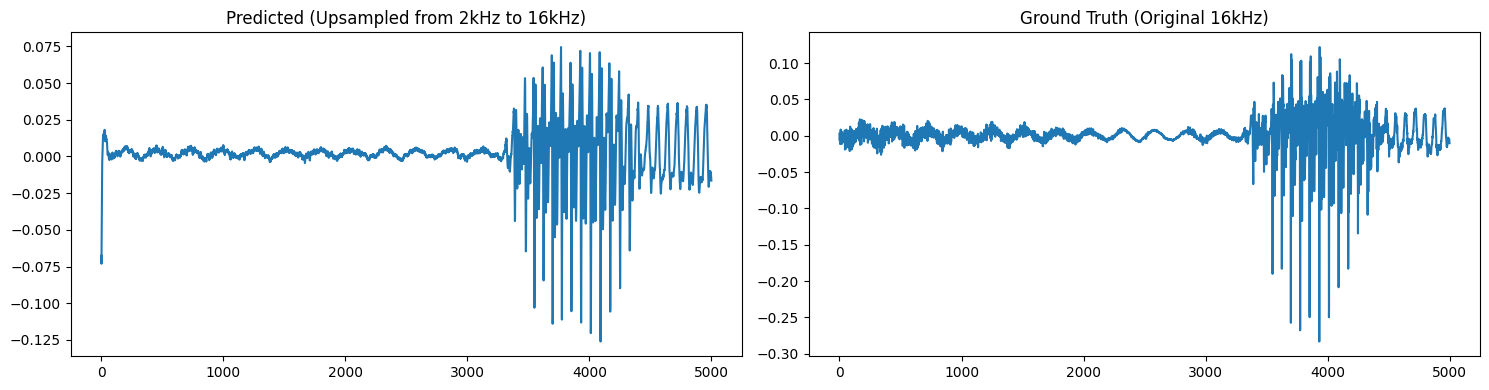

In [33]:

model_path = "/kaggle/working/cnn_audio_eca_model.h5"
cnn_eca_model.save(model_path)
print(f"✅ Model saved to {model_path}")

import matplotlib.pyplot as plt

# Pick a sample
i = 3
low_sr_input = input_data[i].reshape(1, input_len, 1)
predicted = cnn_eca_model.predict(low_sr_input)[0].flatten()
ground_truth = target_data[i].flatten()

output_audio_path = "/kaggle/working/output_predicted_eca3.wav"
sf.write(output_audio_path, predicted, 16000)
print(f"🔊 Predicted audio saved to {output_audio_path}")

gt_audio_path = "/kaggle/working/ground_truth.wav"
sf.write(gt_audio_path, ground_truth, 16000)
print(f"✅ Ground truth saved to {gt_audio_path}")

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(predicted[:5000])
plt.title("Predicted (Upsampled from 2kHz to 16kHz)")

plt.subplot(1, 2, 2)
plt.plot(ground_truth[:5000])
plt.title("Ground Truth (Original 16kHz)")

plt.tight_layout()
plt.show()

In [14]:
from IPython.display import Audio
print("Predicted Output:")
display(Audio(data=predicted.squeeze(), rate=16000))

print("Ground Truth:")
display(Audio(data=ground_truth.squeeze(), rate=16000))


Predicted Output:


Ground Truth:


**CBAM**

In [20]:
def cbam_block_1d(input_tensor, reduction_ratio=8):
    """CBAM Block for 1D inputs (Channel + Spatial Attention)"""

    # ----- Channel Attention -----
    channel = input_tensor.shape[-1]
    
    avg_pool = layers.GlobalAveragePooling1D()(input_tensor)
    max_pool = layers.GlobalMaxPooling1D()(input_tensor)

    shared_dense_1 = layers.Dense(channel // reduction_ratio, activation='relu', use_bias=False)
    shared_dense_2 = layers.Dense(channel, use_bias=False)

    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))

    channel_attention = layers.Add()([avg_out, max_out])
    channel_attention = layers.Activation('sigmoid')(channel_attention)
    channel_attention = layers.Reshape((1, channel))(channel_attention)

    x = layers.Multiply()([input_tensor, channel_attention])

    # ----- Spatial Attention -----
    avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
    max_pool_spatial = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
    concat = layers.Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])

    spatial_attention = layers.Conv1D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    x = layers.Multiply()([x, spatial_attention])

    return x

def create_cnn_sr_model_with_cbam(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv1D(64, kernel_size=9, padding='same', activation='relu')(inputs)
    x = cbam_block_1d(x)

    x = layers.Conv1D(128, kernel_size=5, padding='same', activation='relu')(x)
    x = cbam_block_1d(x)

    x = layers.Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = cbam_block_1d(x)

    x = layers.Conv1DTranspose(128, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(64, kernel_size=4, strides=2, padding='same', activation='relu')(x)
    x = layers.Conv1DTranspose(32, kernel_size=4, strides=2, padding='same', activation='relu')(x)

    outputs = layers.Conv1D(1, kernel_size=9, padding='same', activation='linear')(x)

    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model



cnn_sr_model = create_cnn_sr_model_with_cbam((input_len, 1))
cnn_sr_model.summary()

# ------------------------------
# STEP 4: Train the Model
# ------------------------------

cnn_sr_model.fit(input_data, target_data, epochs=10, batch_size=4)


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 33720, 1)       │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_22 (Conv1D)        │ (None, 33720, 64)      │            640 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 64)             │              0 │ conv1d_22[0][0]        │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 64)             │              0 │ conv1d_22[0][0]        │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 8)              │            512 │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 64)             │            512 │ dense_12[0][0],        │
│                           │                        │                │ dense_12[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 64)             │              0 │ dense_13[0][0],        │
│                           │                        │                │ dense_13[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_6 (Activation) │ (None, 64)             │              0 │ add_3[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_12 (Reshape)      │ (None, 1, 64)          │              0 │ activation_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_12 (Multiply)    │ (None, 33720, 64)      │              0 │ conv1d_22[0][0],       │
│                           │                        │                │ reshape_12[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_6 (Lambda)         │ (None, 33720, 1)       │              0 │ multiply_12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_7 (Lambda)         │ (None, 33720, 1)       │              0 │ multiply_12[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 33720, 2)       │              0 │ lambda_6[0][0],        │
│ (Concatenate)             │                        │                │ lambda_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_23 (Conv1D)        │ (None, 33720, 1)       │             15 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_13 (Multiply)    │ (None, 33720, 64)      │              0 │ multiply_12[0][0],     │
│                           │                        │                │ conv1d_23[0][0]        │
├──────────────────────

 Total params: 334,382 (1.28 MB)

 Trainable params: 334,382 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - loss: 6.1929e-04
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - loss: 6.6896e-04
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - loss: 6.7699e-04
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - loss: 6.5724e-04
Epoch 5/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 6.6150e-04
Epoch 6/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: 6.9410e-04
Epoch 7/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 6.2310e-04
Epoch 8/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - loss: 6.6888e-04
Epoch 9/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - loss: 4.9519e-04
Epoch 10/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - loss: 2.7858e-04


✅ Model saved to /kaggle/working/cnn_audio_cbam_model.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
🔊 Predicted audio saved to /kaggle/working/output_predicted_cbam3.wav
✅ Ground truth saved to /kaggle/working/ground_truth.wav


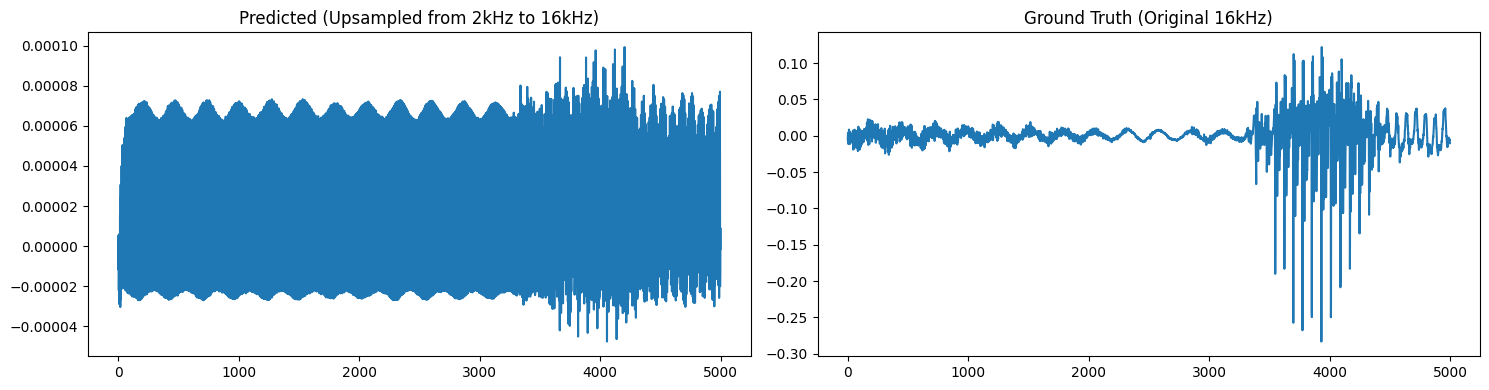

In [35]:
# ------------------------------
# Save the model
# ------------------------------
model_path = "/kaggle/working/cnn_audio_cbam_model.h5"
cnn_cbam_model.save(model_path)
print(f"✅ Model saved to {model_path}")

# ------------------------------
# Test prediction on a sample
# ------------------------------
import matplotlib.pyplot as plt

# Pick a sample
i = 3
low_sr_input = input_data[i].reshape(1, input_len, 1)
predicted = cnn_cbam_model.predict(low_sr_input)[0].flatten()
ground_truth = target_data[i].flatten()

# Save the predicted output as a WAV file
output_audio_path = "/kaggle/working/output_predicted_cbam3.wav"
sf.write(output_audio_path, predicted, 16000)
print(f"🔊 Predicted audio saved to {output_audio_path}")

# Also save ground truth for comparison
gt_audio_path = "/kaggle/working/ground_truth.wav"
sf.write(gt_audio_path, ground_truth, 16000)
print(f"✅ Ground truth saved to {gt_audio_path}")

# ------------------------------
# Plot the waveforms
# ------------------------------
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(predicted[:5000])
plt.title("Predicted (Upsampled from 2kHz to 16kHz)")

plt.subplot(1, 2, 2)
plt.plot(ground_truth[:5000])
plt.title("Ground Truth (Original 16kHz)")

plt.tight_layout()
plt.show()




In [22]:
from IPython.display import Audio
print("Predicted Output:")
display(Audio(data=predicted.squeeze(), rate=16000))

print("Ground Truth:")
display(Audio(data=ground_truth.squeeze(), rate=16000))


Predicted Output:


Ground Truth:


**Interpolation**

In [34]:
import numpy as np
from scipy.interpolate import interp1d
import soundfile as sf
import os

# Your existing low_sr_input (example)
i = 3
low_sr_input = input_data[i].reshape(1, input_len, 1)  # Shape (1, input_len, 1)

# Squeeze to 1D
y = low_sr_input.squeeze()  # Shape (input_len,)

# Define sampling rates
original_sr = 2000   # Low sampling rate
target_sr = 16000    # Target upsampling rate

# Create time axes
duration = len(y) / original_sr
x_old = np.linspace(0, duration, len(y))
x_new = np.linspace(0, duration, int(duration * target_sr))

# Linear interpolation
f_linear = interp1d(x_old, y, kind='linear')
y_linear = f_linear(x_new)
sf.write("/kaggle/working/linear_interp3.wav", y_linear, target_sr)
print(f"✅ Linear interpolation saved at: {os.path.abspath('linear_interp3.wav')}")

# Cubic interpolation
f_cubic = interp1d(x_old, y, kind='cubic')
y_cubic = f_cubic(x_new)
sf.write("/kaggle/working/cubic_interp3.wav", y_cubic, target_sr)
print(f"✅ Cubic interpolation saved at: {os.path.abspath('cubic_interp3.wav')}")

# Nearest-Neighbor interpolation
f_nearest = interp1d(x_old, y, kind='nearest')
y_nearest = f_nearest(x_new)
sf.write("/kaggle/working/nearest_interp3.wav", y_nearest, target_sr)
print(f"✅ Nearest-Neighbor interpolation saved at: {os.path.abspath('nearest_interp3.wav')}")

# Spline interpolation (Quadratic)
f_quadratic = interp1d(x_old, y, kind='quadratic')
y_quadratic = f_quadratic(x_new)
sf.write("/kaggle/working/spline_interp3.wav", y_quadratic, target_sr)
print(f"✅ Spline interpolation saved at: {os.path.abspath('spline_interp3.wav')}")


✅ Linear interpolation saved at: /kaggle/working/linear_interp3.wav
✅ Cubic interpolation saved at: /kaggle/working/cubic_interp3.wav
✅ Nearest-Neighbor interpolation saved at: /kaggle/working/nearest_interp3.wav
✅ Spline interpolation saved at: /kaggle/working/spline_interp3.wav
